# Idea is to create a quick script to pull all the neural network data into a single file for quick access
## CIS-PD Datasetup first

We are going to resample to 25 Hz since the data appears to be irregularly sampled. We will take 1 minute time samples with 15 seconds of overlap (4x the original data which takes up 9 gb of space)

In [1]:
import joblib
import sys, os
sys.path.append(os.path.realpath(".."))

In [2]:
import src.main as main
import pandas as pd
import numpy as np
from importlib import reload
reload(main)

<module 'src.main' from '/home/ms994/beat_pd2/src/main.py'>

In [3]:
labels = pd.read_csv("/home/ms994/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv")
additional_labels = pd.read_csv("/home/ms994/beat_pd/data/cis-pd/data_labels/CIS-PD_Ancillary_Data_IDs_Labels.csv")

In [4]:
demo_data = pd.read_csv("/home/ms994/beat_pd/data/cis-pd/clinical_data/CIS-PD_Demographics.csv")
updrs_1 = pd.read_csv("/home/ms994/beat_pd/data/cis-pd/clinical_data/CIS-PD_UPDRS_Part1_2_4.csv")
updrs_2 = pd.read_csv("/home/ms994/beat_pd/data/cis-pd/clinical_data/CIS-PD_UPDRS_Part3.csv")

In [5]:
updrs_1.head()

,subject_id,Visit,UPDRS_PartI_Total,UPDRS_PartII_Total,UPDRS_4.1,UPDRS_4.2,UPDRS_4.3,UPDRS_4.4,UPDRS_4.5,UPDRS_4.6
0,1000,Baseline,4,5,0,0,1,3,1,1
1,1004,Baseline,13,6,1,3,1,4,3,0
2,1006,Baseline,10,19,0,0,1,0,2,0
3,1007,Baseline,18,9,0,0,2,3,1,2
4,1016,Baseline,15,2,0,0,0,0,0,0


In [6]:
all_data = demo_data.join(updrs_1.set_index("subject_id"), on="subject_id").join(updrs_2.set_index("subject_id").drop(["Visit"], axis=1))

In [7]:
labels = pd.concat([labels, additional_labels])

In [8]:
labels = labels.reset_index()

In [9]:
labels = labels.join(all_data.set_index("subject_id"), how="inner", on="subject_id")

In [10]:
labels = labels.dropna(how="all")
labels = labels.dropna(how="all", axis=1)
pd.isnull(labels).sum(axis=0)/labels.shape[0]

index                 0.000000
measurement_id        0.000000
subject_id            0.000000
on_off                0.041176
dyskinesia            0.303167
tremor                0.179186
Age                   0.000000
Gender                0.000000
Race                  0.020362
Ethnicity             0.000000
Visit                 0.000000
UPDRS_PartI_Total     0.000000
UPDRS_PartII_Total    0.000000
UPDRS_4.1             0.000000
UPDRS_4.2             0.000000
UPDRS_4.3             0.000000
UPDRS_4.4             0.000000
UPDRS_4.5             0.000000
UPDRS_4.6             0.000000
dtype: float64

In [11]:
labels["Visit"].unique() #useless label

array(['Baseline'], dtype=object)

In [12]:
labels = labels.drop(["Race", "Ethnicity", "Visit"], axis=1)

In [13]:
labels.max(axis=0)

index                                                 1857
measurement_id        ffd64945-4be2-47d1-a706-bf3e03cbf3b3
subject_id                                            1051
on_off                                                   4
dyskinesia                                               4
tremor                                                   4
Age                                                     81
Gender                                                Male
UPDRS_PartI_Total                                       25
UPDRS_PartII_Total                                      19
UPDRS_4.1                                                2
UPDRS_4.2                                                3
UPDRS_4.3                                                2
UPDRS_4.4                                                4
UPDRS_4.5                                                3
UPDRS_4.6                                                3
dtype: object

In [14]:
labels.min(axis=0)

index                                                    0
measurement_id        004ed441-24db-4839-8b5d-7465e4ea2a0a
subject_id                                            1000
on_off                                                   0
dyskinesia                                               0
tremor                                                   0
Age                                                     36
Gender                                              Female
UPDRS_PartI_Total                                        4
UPDRS_PartII_Total                                       2
UPDRS_4.1                                                0
UPDRS_4.2                                                0
UPDRS_4.3                                                0
UPDRS_4.4                                                0
UPDRS_4.5                                                0
UPDRS_4.6                                                0
dtype: object

In [15]:
pd.isna(labels).any(axis=0)

index                 False
measurement_id        False
subject_id            False
on_off                 True
dyskinesia             True
tremor                 True
Age                   False
Gender                False
UPDRS_PartI_Total     False
UPDRS_PartII_Total    False
UPDRS_4.1             False
UPDRS_4.2             False
UPDRS_4.3             False
UPDRS_4.4             False
UPDRS_4.5             False
UPDRS_4.6             False
dtype: bool

In [16]:
poss_missing_labels = ["on_off", "dyskinesia", "tremor"]

In [17]:
labels[labels.measurement_id=="014aa655-5dbf-448b-99ad-09fd7776a682"]

,index,measurement_id,subject_id,on_off,dyskinesia,tremor,Age,Gender,UPDRS_PartI_Total,UPDRS_PartII_Total,UPDRS_4.1,UPDRS_4.2,UPDRS_4.3,UPDRS_4.4,UPDRS_4.5,UPDRS_4.6
1962,104,014aa655-5dbf-448b-99ad-09fd7776a682,1018,0.0,0.0,0.0,58,Male,6,2,0,0,0,0,0,0


In [18]:
all_m_id = labels.measurement_id
test_m_id = all_m_id[0]

In [19]:
#lets go and filter data with some utility funcs
from scipy.signal import butter, lfilter

# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

# grabs some filter constants for making bandpass filter
#    order is kinda like strength of filter... higher leads to more ideal filter but has weird interactions near the edges of the filter
#    lower is less ideal but results in less artifacts being generated
#    this is a bit of a cheat anyways, using a lowpass and highpass together, there may be less sketch filter designs applicable
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
def butter_lp_filter(data, lowcut, fs, order=5):
    nyq = 0.5 * fs #just get the highest freq possible (nyquist, and bandgap it!)
    hc = nyq * 0.9 #can't accept exactly nyq
    print("hc:", hc)
    return butter_bandpass_filter(data, lowcut, hyc, fs, order)
def butter_bandgap_filter(data, lowcut, highcut, fs, order=5):
    if highcut is None:
        return butter_bandgap_filter(data, lowcut, fs, order)
    toRemove = butter_bandpass_filter(data, lowcut, highcut, fs, order)
    return data - toRemove

In [20]:
def get_data(m_id):
    return main.read_seq(
        f"/home/ms994/beat_pd/data/cis-pd/training_data/{m_id}.csv",
        t_colname="Timestamp",
        xyz_colnames=["X", "Y", "Z"],
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    )
def get_preprocessed_data(measurement_id, low_f=1, high_f=10):
    data = main.read_seq(
        f"/home/ms994/beat_pd/data/cis-pd/training_data/{measurement_id}.csv",
        t_colname="Timestamp",
        xyz_colnames=["X", "Y", "Z"],
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    )
    timeIndex = data.index
    dataCol = data.columns
    #50 hz, make a bandpass between 1 and 10 hz, with order of 5
    data = butter_bandpass_filter(data, low_f, high_f, 50, 5)
    data = pd.DataFrame(data, index=timeIndex, columns=dataCol)
    return data

In [43]:
def read_mid_and_split(m_id, max_window=pd.Timedelta(seconds=60), overlap=pd.Timedelta(seconds=10)):
    try:
        data = get_data(m_id)
        all_samples = []
        currentIndex = pd.Timedelta(seconds=0)
        while (currentIndex + max_window < data.index.max()):
            all_samples.append(data.loc[currentIndex:currentIndex+max_window].fillna(method="ffill").fillna(method="bfill").values)
            currentIndex += overlap
        return all_samples
    except:
        return []

In [22]:
all_m_id = sorted(all_m_id) #keep a constant m_id

In [23]:
all_m_id[0]

'004ed441-24db-4839-8b5d-7465e4ea2a0a'

In [44]:
def write_data(to_run_q, to_return_q):
    for m_id in iter(to_run_q.get, None):
        data_samples = read_mid_and_split(m_id) 
        label = labels[labels.measurement_id == m_id]
        for data_sample in data_samples:
            to_return_q.put((data_sample, label))

In [25]:
all_m_id[0]

'004ed441-24db-4839-8b5d-7465e4ea2a0a'

In [4]:
from multiprocessing import Process, Manager
m = Manager()
n_process = 12
toRunQ = m.Queue()
toReturnQ = m.Queue()
p = [Process(target=write_data, args=(toRunQ, toReturnQ)) for i in range(n_process)]
[toRunQ.put(m_id) for m_id in all_m_id]
[toRunQ.put(None) for i in range(n_process)]

NameError: name 'write_data' is not defined

In [46]:
[process.start() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [47]:
[process.join() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [48]:
toReturnQ.qsize()

204098

In [49]:
all_subjects = sorted(labels.subject_id.unique())

In [50]:
def gen():
    while not toRunQ.empty() and not toReturnQ.empty():
        data = toReturnQ.get()
        yield parse_datum(data).SerializeToString()

In [51]:
allResults = []
while not toReturnQ.empty():
    allResults.append(toReturnQ.get())

In [52]:
from random import shuffle
shuffle(allResults)

In [34]:
missing = [result[1] if np.isnan(result[0]).any() else None for result in allResults]

In [53]:
np.isnan(np.vstack(read_mid_and_split("005685b2-3de4-469b-b673-8f937ee8196e"))).sum()

0

In [54]:
allLabels = [res[1] for res in allResults]

In [55]:
sum([np.isnan(res[0]).any() for res in allResults])

716

In [57]:
allResults = filter(lambda x: not np.isnan(x[0]).any(), allResults)

In [60]:
allResults = [res for res in allResults]

In [61]:
sum([np.isnan(res[0]).any() for res in allResults])

0

In [62]:
import pickle as pkl
pkl.dump(allResults, open("/n/scratch2/ms994/allZeData.pkl", "wb"))

## set up the eval set

In [63]:
import glob
import pandas as pd

In [64]:
eval_set = glob.glob("/home/ms994/beat_pd/data/test_set/cis-pd/testing_data/*.csv")

In [65]:
def get_data(m_id):
    return main.read_seq(
        f"{m_id}",
        t_colname="Timestamp",
        xyz_colnames=["X", "Y", "Z"],
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    )
def read_mid_and_split(m_id, max_window=pd.Timedelta(seconds=60), overlap=pd.Timedelta(seconds=10)):
#     try:
        data = get_data(m_id)
        all_samples = []
        currentIndex = pd.Timedelta(seconds=0)
        while (currentIndex + max_window < data.index.max()):
            all_samples.append(data.loc[currentIndex:currentIndex+max_window].fillna(method="ffill").fillna(method="bfill").values)
            currentIndex += overlap
        return all_samples
#     except:
#         return []

In [66]:
def write_data(to_run_q, to_return_q):
    for m_id in iter(to_run_q.get, None):
        data_samples = read_mid_and_split(m_id) 
        for data_sample in data_samples:
            to_return_q.put((data_sample, m_id))

In [103]:
all_m_id[0]

'004ed441-24db-4839-8b5d-7465e4ea2a0a'

In [67]:
from multiprocessing import Process, Manager
m = Manager()
n_process = 12
toRunQ = m.Queue()
toReturnQ = m.Queue()
p = [Process(target=write_data, args=(toRunQ, toReturnQ)) for i in range(n_process)]
[toRunQ.put(m_id) for m_id in eval_set]
[toRunQ.put(None) for i in range(n_process)]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [68]:
[process.start() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [69]:
[process.join() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [70]:
toRunQ.qsize()

0

In [108]:
all_subjects = sorted(labels.subject_id.unique())

In [71]:
def gen():
    while not toRunQ.empty() and not toReturnQ.empty():
        data = toReturnQ.get()
        yield parse_datum(data).SerializeToString()

In [112]:
allEvalResults = []
while not toReturnQ.empty():
    allEvalResults.append(toReturnQ.get())

In [76]:
from random import shuffle
shuffle(allEvalResults)
allEvalResults = filter(lambda x: not np.isnan(x[0]).any(), allEvalResults)
allEvalResults = [res for res in allEvalResults]

In [113]:
import pickle as pkl
pkl.dump(allEvalResults, open("/n/scratch2/ms994/cispdEvalset.pkl", "wb"))

In [78]:
sum([np.isnan(res[0]).any() for res in allEvalResults])

0

In [79]:
import pickle as pkl
allResults = pkl.load(open("/n/scratch2/ms994/allZeData.pkl", "rb"))

# TFRecords setup
reduces memory usage to maintain slurm sshare fair usage credits

In [84]:
import tensorflow as tf
# Helperfunctions to make your feature definition more readable
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _int64_feature_list(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
# Helperfunctions to make your feature definition more readable
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _float_feature_list(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))
def parse_datum(datum):
    xData = datum[0]
    yData = datum[1].fillna(-1) #using -1 as a masking value
    
    
    
    feature = { \
               'data': _float_feature_list(xData[:1500].reshape(-1)), \
               'on_off': _int64_feature_list(yData.on_off.values.astype(int)), \
               'dyskinesia': _int64_feature_list(yData.dyskinesia.values.astype(int)), \
               'measurement_id': _int64_feature(all_m_id.index(yData.measurement_id.values[0])), \
               'tremor': _int64_feature_list(yData.tremor.values.astype(int)), \
               'age': _int64_feature_list(yData.Age.values.astype(int)), \
               'subjects': _int64_feature(all_subjects.index(yData.subject_id.values[0])),
               'gender': _int64_feature_list(yData.Gender.apply(lambda x: x=="Male").values.astype(int)), \
               'UPDRS_PartI_Total': _int64_feature_list(yData.UPDRS_PartI_Total.values.astype(int)), \
               'UPDRS_PartII_Total': _int64_feature_list(yData.UPDRS_PartII_Total.values.astype(int)), \
               'UPDRS_4.1': _int64_feature_list(yData["UPDRS_4.1"].values.astype(int)), \
               'UPDRS_4.2': _int64_feature_list(yData["UPDRS_4.2"].values.astype(int)), \
               'UPDRS_4.3': _int64_feature_list(yData["UPDRS_4.3"].values.astype(int)), \
               'UPDRS_4.4': _int64_feature_list(yData["UPDRS_4.4"].values.astype(int)), \
               'UPDRS_4.5': _int64_feature_list(yData["UPDRS_4.5"].values.astype(int)), \
               'UPDRS_4.6': _int64_feature_list(yData["UPDRS_4.6"].values.astype(int)),
              }
    return tf.train.Example(features=tf.train.Features(feature=feature))

ImportError: Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
# all_m_id = all_m_id.tolist()
all_subjects = labels.subject_id.unique().tolist()

In [ ]:
#cuz im having issues with pulling directly off queue
def gen():
    for datum in allResults:
        yield parse_datum(datum).SerializeToString()

In [ ]:
import tensorflow as tf
from importlib import reload
reload(tf)
tf.__version__

In [44]:
dataset = tf.data.Dataset.from_generator(gen, output_types=tf.string,  output_shapes=(tf.TensorShape([])))
writer = tf.data.experimental.TFRecordWriter("/n/scratch2/beat_pd_ms_tmp/all_data.tfr")
writer.write(dataset)

In [ ]:
# %%bash
# scancel 2919535

## Confirm TFRecords data correctly wrote down
Confirmation that data is correct

In [3]:
import tensorflow as tf
tf.enable_eager_execution()
# Helperfunctions to make your feature definition more readable

def read_tfrecord(example):
    features = { \
                'data':  tf.io.FixedLenFeature([1500*3], tf.float32,),\
                'on_off':  tf.io.FixedLenFeature([1], tf.int64,),\
                'dyskinesia':  tf.io.FixedLenFeature([1], tf.int64,),
                'measurement_id':  tf.io.FixedLenFeature([1], tf.int64,),\
                'tremor':  tf.io.FixedLenFeature([1], tf.int64,), \
                'age':  tf.io.FixedLenFeature([1], tf.int64,), \
                "subjects": tf.io.FixedLenFeature([1], tf.int64), \
                "gender": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_PartI_Total": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_PartII_Total": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.1": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.2": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.3": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.4": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.5": tf.io.FixedLenFeature([1], tf.int64), \
                "UPDRS_4.6": tf.io.FixedLenFeature([1], tf.int64)
               }

    example = tf.io.parse_single_example(example, features)
    return example
def map_example_to_simple(example):
    data = example['data']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0],)
dataset = tf.data.Dataset.list_files("/n/scratch2/beat_pd_ms_tmp/all_data.tfr")
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
dataset = dataset.with_options(option_no_order)
dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)

dataset = dataset.map(read_tfrecord, num_parallel_calls=1)

In [ ]:
iterator = dataset.take(20000).make_one_shot_iterator()

In [30]:
m_id = []
on_off = []

for i in iterator:
    m_id.append(i["measurement_id"][0].numpy())
    on_off.append(i["on_off"][0].numpy())    

NameError: name 'iterator' is not defined

In [ ]:
df = pd.DataFrame([m_id, on_off])

# RealPD  Combined

In [65]:
train_watch_accel = glob.glob("/home/ms994/beat_pd/data/real-pd/training_data/smartwatch_accelerometer/*.csv")
train_watch_gyro = glob.glob("/home/ms994/beat_pd/data/real-pd/training_data/smartwatch_gyroscope/*.csv")
train_phone_accel = glob.glob("/home/ms994/beat_pd/data/real-pd/training_data/smartphone_accelerometer/*.csv")

In [66]:
len(train_watch_accel), len(train_watch_gyro), len(train_phone_accel)

(535, 535, 526)

In [108]:
data = get_data(all_m_id[1000])

In [109]:
allData = pd.concat(data, axis=1)

In [110]:
allData.columns = ["smartwatch_acc_x", "smartwatch_acc_y", "smartwatch_acc_z", "smartwatch_gyro_x", "smartwatch_gyro_y", "smartwatch_gyro_z", "smartphone_acc_x", "smartphone_acc_y", "smartphone_acc_z"]

In [111]:
allData

,smartwatch_acc_x,smartwatch_acc_y,smartwatch_acc_z,smartwatch_gyro_x,smartwatch_gyro_y,smartwatch_gyro_z,smartphone_acc_x,smartphone_acc_y,smartphone_acc_z
t,,,,,,,,,
00:00:00,3.058832,-3.305914,1.822466,0.000637,0.014443,-0.023152,8.033894,-3.503017,4.325724
00:00:00.040000,-1.412579,-5.088477,1.173159,0.002655,0.012479,-0.030268,8.015937,-3.482067,4.367623
00:00:00.080000,3.071282,-3.314533,1.787032,0.010089,0.009558,-0.031064,8.038083,-3.471293,4.347871
00:00:00.120000,1.437718,-3.975572,1.564611,0.011947,0.006372,-0.028940,8.045864,-3.411438,4.338294
00:00:00.160000,-1.329580,-5.112419,1.099737,0.007700,0.012744,-0.028940,8.053047,-3.453935,4.404134
00:00:00.200000,1.367089,-4.011485,1.629254,-0.002921,0.015665,-0.029737,8.038682,-3.440767,4.390368
00:00:00.240000,1.385046,-3.986346,1.551443,0.007965,0.015133,-0.030267,8.002171,-3.454534,4.395156
00:00:00.280000,1.371878,-4.003105,1.593341,0.001328,0.011151,-0.024692,8.014740,-3.457526,4.379593
00:00:00.320000,1.351527,-3.985148,1.595736,0.017523,0.003717,-0.024161,8.028307,-3.473488,4.363233


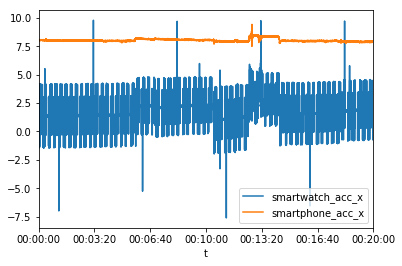

In [112]:
import matplotlib.pyplot as plt
allData[["smartwatch_acc_x", "smartphone_acc_x",]].plot()
plt.show()

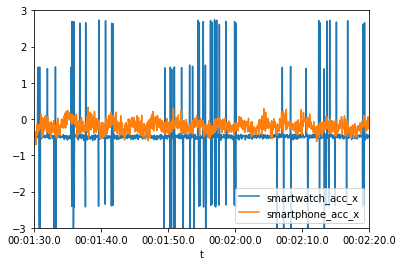

In [115]:
import matplotlib.pyplot as plt
subsampData = allData[["smartwatch_acc_x", "smartphone_acc_x",]]
subsampData = (subsampData - subsampData.mean(0))  / subsampData.std(axis=0)
subsampData.loc[pd.Timedelta(seconds=90):pd.Timedelta(seconds=140)].plot()
plt.ylim([-3,3])
plt.show()

In [93]:
import os.path
def get_data(m_id):
    allData = []
    subdirs = ["smartwatch_accelerometer", "smartwatch_gyroscope", "smartphone_accelerometer"]
    for subdir in subdirs:
        if os.path.isfile(f"/home/ms994/beat_pd/data/real-pd/training_data/{subdir}/{m_id}.csv"):
            allData.append(main.read_seq(
            f"/home/ms994/beat_pd/data/real-pd/training_data/{subdir}/{m_id}.csv",
            use_time_index=True,
            resample=pd.Timedelta(seconds=1/25)).fillna(method="bfill").fillna(method="ffill"))
        else:
            allData.append(pd.DataFrame(index=pd.timedelta_range(start=pd.Timedelta(seconds=0), freq=pd.Timedelta(seconds=1/25), end = pd.Timedelta(minutes=20))))
    return allData
def read_mid_and_split(m_id, max_window=pd.Timedelta(seconds=60), overlap=pd.Timedelta(seconds=10)):
        data = get_data(m_id)
        
        all_samples = []
        currentIndex = pd.Timedelta(seconds=0)
        while (currentIndex + max_window < data.index.max()):
            all_samples.append(data.loc[currentIndex:currentIndex+max_window].fillna(method="ffill").fillna(method="bfill").values)
            currentIndex += overlap
        return all_samples

# RealPD Smartwatch
## RealPD data setup

In [3]:
labels = pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv")
additional_labels = pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Ancillary_Data_IDs_Labels.csv")

In [90]:
demo_data = pd.read_csv("/home/ms994/beat_pd/data/real-pd/clinical_data/REAL-PD_Demographics.csv")
updrs_1 = pd.read_csv("/home/ms994/beat_pd/data/real-pd/clinical_data/REAL-PD_UPDRS_Part1_2_4.csv")
updrs_2 = pd.read_csv("/home/ms994/beat_pd/data/real-pd/clinical_data/REAL-PD_UPDRS_Part3.csv")

In [91]:
all_data = demo_data.join(updrs_1.set_index("subject_id"), on="subject_id").join(updrs_2.set_index("subject_id"))

In [92]:
labels = pd.concat([labels, additional_labels])

In [93]:
labels = labels.reset_index()

In [94]:
labels = labels.join(all_data.set_index("subject_id"), how="inner", on="subject_id")

In [87]:
def get_data(m_id):
    return main.read_seq(
        f"/home/ms994/beat_pd/data/real-pd/training_data/smartwatch_accelerometer/{m_id}.csv",
        
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    ).fillna(method="bfill").fillna(method="ffill")
def get_preprocessed_data(measurement_id, low_f=1, high_f=10):
    data = main.read_seq(
        f"/home/ms994/beat_pd/data/real-pd/training_data/{measurement_id}.csv",
        t_colname="Timestamp",
        xyz_colnames=["X", "Y", "Z"],
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    )
    timeIndex = data.index
    dataCol = data.columns
    #50 hz, make a bandpass between 1 and 10 hz, with order of 5
    data = butter_bandpass_filter(data, low_f, high_f, 50, 5)
    data = pd.DataFrame(data, index=timeIndex, columns=dataCol)
    return data

In [88]:
def read_mid_and_split(m_id, max_window=pd.Timedelta(seconds=60), overlap=pd.Timedelta(seconds=10)):
        data = get_data(m_id)
        all_samples = []
        currentIndex = pd.Timedelta(seconds=0)
        while (currentIndex + max_window < data.index.max()):
            all_samples.append(data.loc[currentIndex:currentIndex+max_window].fillna(method="ffill").fillna(method="bfill").values)
            currentIndex += overlap
        return all_samples

In [95]:
all_m_id = labels.measurement_id
test_m_id = all_m_id[0]
all_m_id = sorted(all_m_id) #keep a constant m_id

In [96]:
all_m_id[0]

'00a49337-386c-4de3-a220-4cf3c0d20a7d'

In [97]:
def write_data(to_run_q, to_return_q):
        for m_id in iter(to_run_q.get, None):
            try:
                data_samples = read_mid_and_split(m_id) 
                label = labels[labels.measurement_id == m_id]
                for data_sample in data_samples:
                    to_return_q.put((data_sample, label))
            except:
                print("fail")
        

In [98]:
from multiprocessing import Process, Manager
m = Manager()
n_process = 12
toRunQ = m.Queue()
toReturnQ = m.Queue()
p = [Process(target=write_data, args=(toRunQ, toReturnQ)) for i in range(n_process)]
[toRunQ.put(m_id) for m_id in all_m_id]
[toRunQ.put(None) for i in range(n_process)]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [99]:
[process.start() for process in p]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


[None, None, None, None, None, None, None, None, None, None, None, None]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


In [102]:
toReturnQ.qsize()

58478

In [100]:
[process.join() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [132]:
toRunQ.qsize()

0

In [103]:
all_subjects = sorted(labels.subject_id.unique())

In [104]:
def gen():
    while not toRunQ.empty() and not toReturnQ.empty():
        data = toReturnQ.get()
        yield parse_datum(data).SerializeToString()

In [105]:
allResults = []
while not toReturnQ.empty():
    allResults.append(toReturnQ.get())

In [106]:
from random import shuffle
shuffle(allResults)

In [112]:
sum([np.isnan(res[0]).any() for res in allResults])

0

In [110]:
import pickle as pkl
pkl.dump(allResults, open("/n/scratch2/ms994/realPDdata.pkl","wb"))

In [ ]:
all

In [111]:
allResults = pkl.load(open("/n/scratch2/ms994/realPDdata.pkl","rb"))

## Eval

In [5]:
import glob
import pandas as pd

In [6]:
eval_set = glob.glob("/home/ms994/beat_pd/data/test_set/real-pd/testing_data/smartwatch_accelerometer/*.csv")

In [7]:
def get_data(m_id):
    return main.read_seq(
        f"{m_id}",
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    ).fillna(method="ffill").fillna(method="bfill")
def read_mid_and_split(m_id, max_window=pd.Timedelta(seconds=60), overlap=pd.Timedelta(seconds=10)):
    try:
        data = get_data(m_id)
        all_samples = []
        currentIndex = pd.Timedelta(seconds=0)
        while (currentIndex + max_window < data.index.max()):
            all_samples.append(data.loc[currentIndex:currentIndex+max_window].fillna(method="ffill").fillna(method="bfill").values)
            currentIndex += overlap
        return all_samples
    except:
        return []

In [8]:
def write_data(to_run_q, to_return_q):
    for m_id in iter(to_run_q.get, None):
        data_samples = read_mid_and_split(m_id) 
        for data_sample in data_samples:
            to_return_q.put((data_sample, m_id))

In [10]:
from multiprocessing import Process, Manager
m = Manager()
n_process = 12
toRunQ = m.Queue()
toReturnQ = m.Queue()
p = [Process(target=write_data, args=(toRunQ, toReturnQ)) for i in range(n_process)]
[toRunQ.put(m_id) for m_id in eval_set]
[toRunQ.put(None) for i in range(n_process)]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [11]:
[process.start() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [12]:
[process.join() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [15]:
toReturnQ.qsize()

19071

In [ ]:
all_subjects = sorted(labels.subject_id.unique())

In [14]:
def gen():
    while not toRunQ.empty() and not toReturnQ.empty():
        data = toReturnQ.get()
        yield parse_datum(data).SerializeToString()

In [16]:
allEvalResults = []
while not toReturnQ.empty():
    allEvalResults.append(toReturnQ.get())

In [17]:
from random import shuffle
shuffle(allEvalResults)

In [18]:
len(allEvalResults)

19071

In [20]:
import pickle as pkl
pkl.dump(allEvalResults, open("/n/scratch2/ms994/realpdSmartwatchEvalset.pkl", "wb"))

# Real PD Smartphone Accel

In [25]:
%%bash
ls /home/ms994/beat_pd/data/test_set/real-pd/testing_data/

smartphone_accelerometer
smartwatch_accelerometer
smartwatch_gyroscope


In [26]:
labels = pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv")
additional_labels = pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Ancillary_Data_IDs_Labels.csv")

In [27]:
demo_data = pd.read_csv("/home/ms994/beat_pd/data/real-pd/clinical_data/REAL-PD_Demographics.csv")
updrs_1 = pd.read_csv("/home/ms994/beat_pd/data/real-pd/clinical_data/REAL-PD_UPDRS_Part1_2_4.csv")
updrs_2 = pd.read_csv("/home/ms994/beat_pd/data/real-pd/clinical_data/REAL-PD_UPDRS_Part3.csv")

In [28]:
all_data = demo_data.join(updrs_1.set_index("subject_id"), on="subject_id").join(updrs_2.set_index("subject_id"))

In [29]:
labels = pd.concat([labels, additional_labels])

In [30]:
labels = labels.reset_index()

In [31]:
labels = labels.join(all_data.set_index("subject_id"), how="inner", on="subject_id")

In [32]:
def get_data(m_id):
    return main.read_seq(
        f"/home/ms994/beat_pd/data/real-pd/training_data/smartphone_accelerometer/{m_id}.csv",
        
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    ).fillna(method="bfill").fillna(method="ffill")
def get_preprocessed_data(measurement_id, low_f=1, high_f=10):
    data = main.read_seq(
        f"/home/ms994/beat_pd/data/real-pd/training_data/{measurement_id}.csv",
        t_colname="Timestamp",
        xyz_colnames=["X", "Y", "Z"],
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    )
    timeIndex = data.index
    dataCol = data.columns
    #50 hz, make a bandpass between 1 and 10 hz, with order of 5
    data = butter_bandpass_filter(data, low_f, high_f, 50, 5)
    data = pd.DataFrame(data, index=timeIndex, columns=dataCol)
    return data

In [33]:
def read_mid_and_split(m_id, max_window=pd.Timedelta(seconds=60), overlap=pd.Timedelta(seconds=10)):
        data = get_data(m_id)
        all_samples = []
        currentIndex = pd.Timedelta(seconds=0)
        while (currentIndex + max_window < data.index.max()):
            all_samples.append(data.loc[currentIndex:currentIndex+max_window].fillna(method="ffill").fillna(method="bfill").values)
            currentIndex += overlap
        return all_samples

In [34]:
all_m_id = labels.measurement_id
test_m_id = all_m_id[0]
all_m_id = sorted(all_m_id) #keep a constant m_id

In [35]:
all_m_id[0]

'00a49337-386c-4de3-a220-4cf3c0d20a7d'

In [36]:
def write_data(to_run_q, to_return_q):
        for m_id in iter(to_run_q.get, None):
            try:
                data_samples = read_mid_and_split(m_id) 
                label = labels[labels.measurement_id == m_id]
                for data_sample in data_samples:
                    to_return_q.put((data_sample, label))
            except:
                print("fail")
        

In [37]:
from multiprocessing import Process, Manager
m = Manager()
n_process = 12
toRunQ = m.Queue()
toReturnQ = m.Queue()
p = [Process(target=write_data, args=(toRunQ, toReturnQ)) for i in range(n_process)]
[toRunQ.put(m_id) for m_id in all_m_id]
[toRunQ.put(None) for i in range(n_process)]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [38]:
[process.start() for process in p]

fail
fail
fail
fail
fail
fail
fail


[None, None, None, None, None, None, None, None, None, None, None, None]

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


In [102]:
toReturnQ.qsize()

58478

In [39]:
[process.join() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [132]:
toRunQ.qsize()

0

In [40]:
all_subjects = sorted(labels.subject_id.unique())

In [104]:
def gen():
    while not toRunQ.empty() and not toReturnQ.empty():
        data = toReturnQ.get()
        yield parse_datum(data).SerializeToString()

In [41]:
allResults = []
while not toReturnQ.empty():
    allResults.append(toReturnQ.get())

In [42]:
from random import shuffle
shuffle(allResults)

In [46]:
sum([np.isnan(res[0]).any() for res in allResults])

0

In [44]:
import pickle as pkl
pkl.dump(allResults, open("/n/scratch2/ms994/realPDSmartphoneAcceldata.pkl","wb"))

In [45]:
allResults = pkl.load(open("/n/scratch2/ms994/realPDSmartphoneAcceldata.pkl","rb"))

## Eval

In [47]:
import glob
import pandas as pd

In [48]:
eval_set = glob.glob("/home/ms994/beat_pd/data/test_set/real-pd/testing_data/smartphone_accelerometer/*.csv")

In [49]:
def get_data(m_id):
    return main.read_seq(
        f"{m_id}",
        use_time_index=True,
        resample=pd.Timedelta(seconds=1/25)
    ).fillna(method="ffill").fillna(method="bfill")
def read_mid_and_split(m_id, max_window=pd.Timedelta(seconds=60), overlap=pd.Timedelta(seconds=10)):
    try:
        data = get_data(m_id)
        all_samples = []
        currentIndex = pd.Timedelta(seconds=0)
        while (currentIndex + max_window < data.index.max()):
            all_samples.append(data.loc[currentIndex:currentIndex+max_window].fillna(method="ffill").fillna(method="bfill").values)
            currentIndex += overlap
        return all_samples
    except:
        return []

In [50]:
def write_data(to_run_q, to_return_q):
    for m_id in iter(to_run_q.get, None):
        data_samples = read_mid_and_split(m_id) 
        for data_sample in data_samples:
            to_return_q.put((data_sample, m_id))

In [51]:
from multiprocessing import Process, Manager
m = Manager()
n_process = 12
toRunQ = m.Queue()
toReturnQ = m.Queue()
p = [Process(target=write_data, args=(toRunQ, toReturnQ)) for i in range(n_process)]
[toRunQ.put(m_id) for m_id in eval_set]
[toRunQ.put(None) for i in range(n_process)]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [11]:
[process.start() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [12]:
[process.join() for process in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [52]:
toReturnQ.qsize()

0

In [ ]:
all_subjects = sorted(labels.subject_id.unique())

In [14]:
def gen():
    while not toRunQ.empty() and not toReturnQ.empty():
        data = toReturnQ.get()
        yield parse_datum(data).SerializeToString()

In [16]:
allEvalResults = []
while not toReturnQ.empty():
    allEvalResults.append(toReturnQ.get())

In [53]:
from random import shuffle
shuffle(allEvalResults)

In [54]:
len(allEvalResults)

19071

In [55]:
import pickle as pkl
pkl.dump(allEvalResults, open("/n/scratch2/ms994/realpdSmartphoneEvalset.pkl", "wb"))

# Checkout RealPD smartwatch gyro

In [58]:
gyro = glob.glob("/home/ms994/beat_pd/data/test_set/real-pd/testing_data/smartwatch_gyroscope/*.csv")

In [62]:
len(gyro), len(glob.glob("/home/ms994/beat_pd/data/test_set/real-pd/testing_data/smartwatch_accelerometer/*.csv")), len(glob.glob("/home/ms994/beat_pd/data/test_set/real-pd/testing_data/smartphone_accelerometer/*.csv"))

(172, 172, 169)